# Análisis Exploratorio de Datos: Retail Superstore

## 1. Configuración del Entorno
Importamos las librerías necesarias para la manipulación de datos (Pandas), cálculos numéricos (Numpy) y visualización (Matplotlib/Seaborn).# Análisis Exploratorio de Datos (EDA): Caso Retail Superstore


## 1. Introducción y Objetivos
Este cuaderno presenta el análisis exploratorio del dataset "Superstore", una cadena minorista estadounidense.

**El objetivo principal** es comprender el comportamiento histórico de las ventas para fundamentar la construcción de modelos de pronóstico (SARIMA y XGBoost).

**Preguntas clave a responder:**
1. ¿Cuál es la tendencia general de las ventas a lo largo de los 4 años?
2. ¿Existe una estacionalidad clara que justifique el uso de modelos estacionales?
3. ¿Qué categorías y regiones impulsan el negocio?
4. ¿Cómo afecta el descuento a la rentabilidad (Profit)?

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot

# Configuración visual para gráficos profesionales
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12

# Desactivar advertencias de pandas para una presentación limpia
import warnings
warnings.filterwarnings('ignore')

print("✅ Librerías cargadas y configuración visual establecida.")

✅ Librerías cargadas y configuración visual establecida.


## 2. Carga, Limpieza y Preprocesamiento
El éxito de un modelo de pronóstico depende en un 80% de la calidad de los datos. En esta sección realizamos:

1.  **Carga:** Importación del archivo Excel crudo.
2.  **Estandarización:** Conversión de nombres de columnas a formato *snake_case* (estándar de Python) para facilitar la manipulación programática.
3.  **Casting de Fechas:** Conversión crítica de las columnas `Order Date` y `Ship Date` al formato `datetime`. Sin esto, el análisis de series de tiempo es imposible.
4.  **Ordenamiento:** El dataset debe estar ordenado cronológicamente para calcular rezagos (lags) correctamente.

In [23]:
# Definir ruta relativa al archivo de datos (Buenas prácticas de ingeniería de software)
file_path = os.path.join('..', 'data', 'US Superstore data.xls')

try:
    # Carga del dataset
    df = pd.read_excel(file_path)
    
    # 1. Estandarización de columnas (Snake Case)
    # Elimina espacios y convierte a minúsculas (ej: 'Order Date' -> 'order_date')
    df.columns = df.columns.str.replace(' ', '_').str.replace('-', '_').str.lower()
    
    # 2. Conversión de Fechas (Casting)
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['ship_date'] = pd.to_datetime(df['ship_date'])
    
    # 3. Ordenar cronológicamente por fecha de orden
    df = df.sort_values('order_date')
    
    # Validación de resultados
    print(f" Datos cargados exitosamente.")
    print(f" Dimensiones del Dataset: {df.shape[0]} filas, {df.shape[1]} columnas")
    print(f" Rango Temporal: {df['order_date'].min().date()} hasta {df['order_date'].max().date()}")
    print(f" Columnas detectadas: {list(df.columns)}")

except FileNotFoundError:
    print(f" Error Crítico: No se encontró el archivo en la ruta: {file_path}")
    print("Por favor verifique que la carpeta 'data' existe y contiene el archivo excel.")

# Vista previa de las primeras filas para verificación visual
df.head(3)

 Datos cargados exitosamente.
 Dimensiones del Dataset: 9994 filas, 21 columnas
 Rango Temporal: 2014-01-03 hasta 2017-12-30
 Columnas detectadas: ['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode', 'customer_id', 'customer_name', 'segment', 'country', 'city', 'state', 'postal_code', 'region', 'product_id', 'category', 'sub_category', 'product_name', 'sales', 'quantity', 'discount', 'profit']


,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,postal_code,region,product_id,category,sub_category,product_name,sales,quantity,discount,profit
7980,7981,CA-2014-103800,2014-01-03,2014-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,77095,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512
739,740,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,60540,Central,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784,3,0.2,4.2717
740,741,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,60540,Central,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736,3,0.2,-64.7748


## 3. Análisis de Series de Tiempo: Tendencia Global
Para comprender la demanda, transformaremos los datos transaccionales en una serie de tiempo regular.

**Metodología:**
Agrupamos las ventas totales a nivel **mensual**. Esto reduce el "ruido" diario (ventas muy variables día a día) y nos permite visualizar claramente:
1.  **Tendencia:** ¿El negocio está creciendo?
2.  **Ciclos:** ¿Hay meses consistentemente altos o bajos?

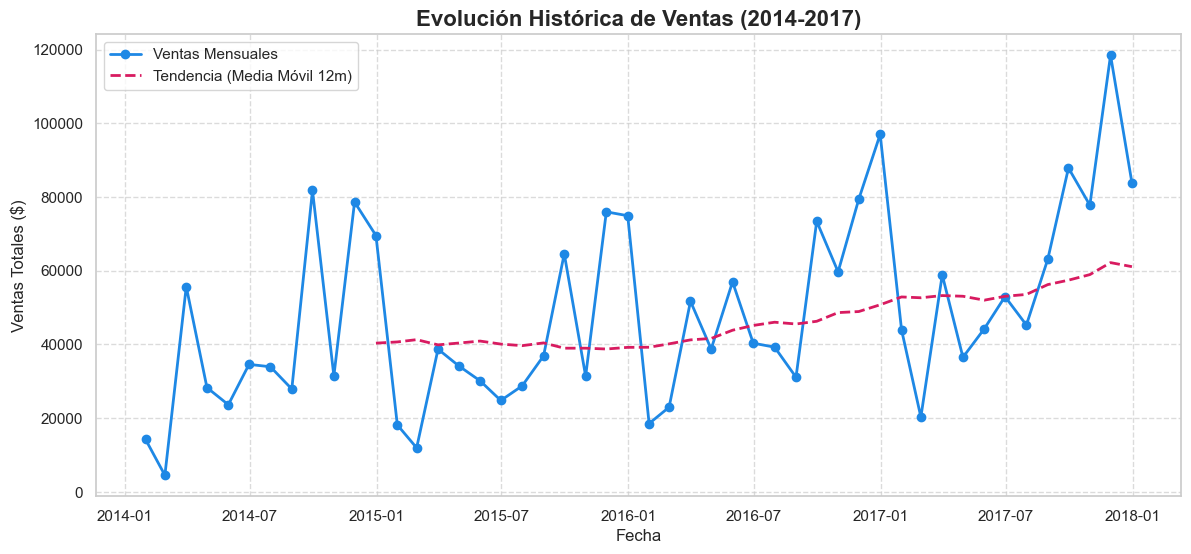

📈 Observación: La serie muestra una clara tendencia ascendente y picos repetitivos al final de cada año.


In [24]:
# 1. Establecer el índice temporal
# Esto permite a Pandas tratar el dataframe como una serie de tiempo
df_ts = df.set_index('order_date')

# 2. Re-muestreo (Resampling) a Fin de Mes ('ME')
# Sumamos todas las ventas ocurridas dentro de cada mes
monthly_sales = df_ts['sales'].resample('ME').sum()

# 3. Visualización Profesional
plt.figure(figsize=(14, 6))
plt.plot(monthly_sales, marker='o', linestyle='-', color='#1E88E5', linewidth=2, label='Ventas Mensuales')

# Línea de tendencia suavizada (Media Móvil de 12 meses) para resaltar el crecimiento
rolling_mean = monthly_sales.rolling(window=12).mean()
plt.plot(rolling_mean, color='#D81B60', linestyle='--', linewidth=2, label='Tendencia (Media Móvil 12m)')

plt.title('Evolución Histórica de Ventas (2014-2017)', fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Ventas Totales ($)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.show()

print(f"📈 Observación: La serie muestra una clara tendencia ascendente y picos repetitivos al final de cada año.")

### 3.1 Descomposición de la Serie (Validación de SARIMA)
Para validar el uso de un modelo **SARIMA** (Seasonal ARIMA), es requisito indispensable demostrar que existe un patrón estacional repetitivo.

Utilizamos la técnica de descomposición aditiva para separar la serie en tres componentes:
* **Tendencia (Trend):** La dirección a largo plazo del negocio.
* **Estacionalidad (Seasonal):** Patrones que se repiten exactamente cada 12 meses.
* **Residuo (Resid):** Fluctuaciones aleatorias no explicadas por lo anterior.

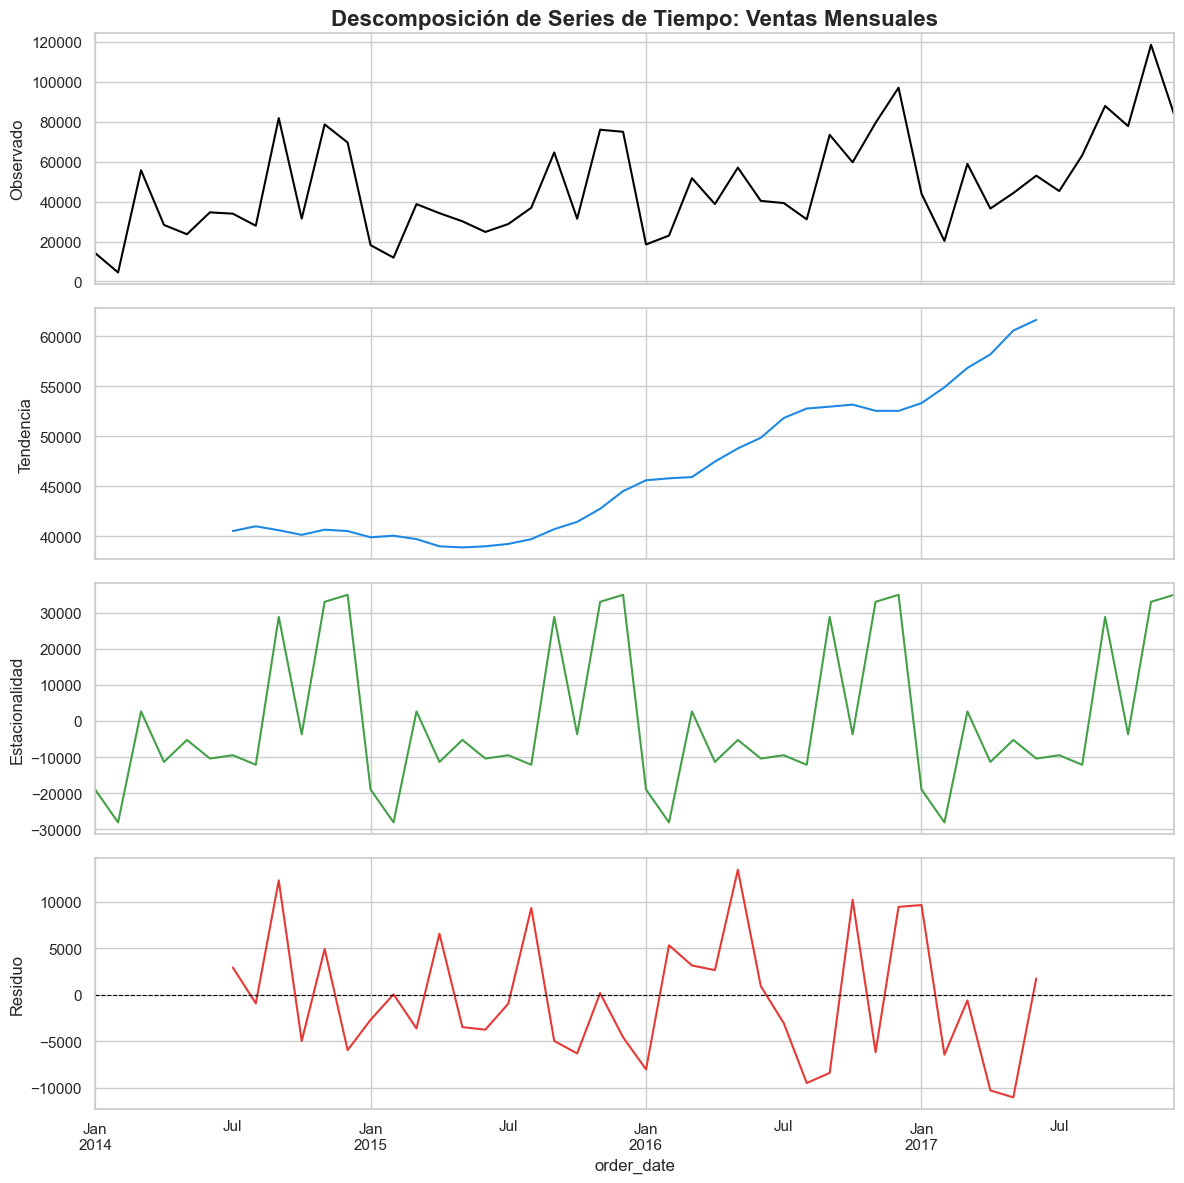

✅ Interpretación: El gráfico verde ('Estacionalidad') muestra ondas perfectas que se repiten cada año.
   Esto CONFIRMA la necesidad de usar SARIMA con seasonal_order=(..., 12).


In [ ]:
# Ejecutar la descomposición (model='additive' porque la amplitud de los picos es constante)
decomposition = seasonal_decompose(monthly_sales, model='additive')

# Crear un panel de 4 gráficos
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# 1. Serie Original
decomposition.observed.plot(ax=ax1, color='black', legend=False)
ax1.set_ylabel('Observado')
ax1.set_title('Descomposición de Series de Tiempo: Ventas Mensuales', fontweight='bold')

# 2. Tendencia (Trend)
decomposition.trend.plot(ax=ax2, color='#1E88E5', legend=False)
ax2.set_ylabel('Tendencia')

# 3. Estacionalidad (Seasonal) 
decomposition.seasonal.plot(ax=ax3, color='#43A047', legend=False)
ax3.set_ylabel('Estacionalidad')

# 4. Residuo (Ruido)
decomposition.resid.plot(ax=ax4, color='#E53935', legend=False)
ax4.set_ylabel('Residuo')
ax4.axhline(0, color='black', linestyle='--', linewidth=0.8) 

plt.tight_layout()
plt.show()

print("✅ Interpretación: El gráfico verde ('Estacionalidad') muestra ondas perfectas que se repiten cada año.")
print("   Esto CONFIRMA la necesidad de usar SARIMA con seasonal_order=(..., 12).")

## 4. Análisis de Autocorrelación (Justificación para XGBoost)

A diferencia de SARIMA, los modelos de Machine Learning como **XGBoost** no tienen un concepto nativo de "tiempo". Para que funcionen, debemos transformar la serie temporal en un problema de aprendizaje supervisado mediante **Ingeniería de Características (Feature Engineering)**.

Analizamos la **Autocorrelación (ACF)** para responder:
* ¿La venta de hoy depende de la venta de ayer? (**Lag 1**)
* ¿La venta de este mes depende del mismo mes del año pasado? (**Lag 12**)

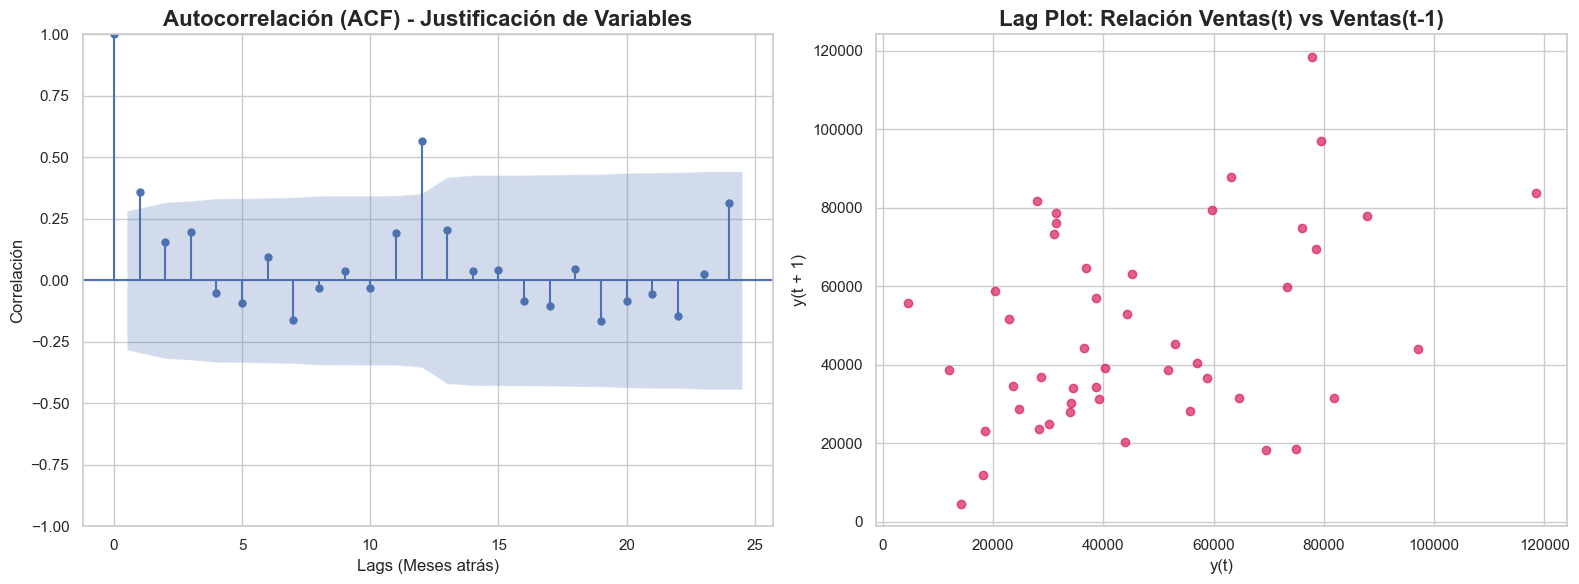

✅ Interpretación: Observamos un pico significativo en el Lag 12.
   Esto justifica crear la variable 'lag_12' (Ventas del año anterior) para el modelo XGBoost.


In [26]:
# Importaciones necesarias para este gráfico
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import lag_plot

# Configuración del gráfico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Función de Autocorrelación (ACF)
# Buscamos picos en el lag 12 (anual)
# Nota: El argumento 'color' no es estándar en todas las versiones de plot_acf,
# así que lo quitamos para asegurar compatibilidad o usamos el estilo por defecto.
plot_acf(monthly_sales, lags=24, ax=ax1)
ax1.set_title('Autocorrelación (ACF) - Justificación de Variables', fontweight='bold')
ax1.set_xlabel('Lags (Meses atrás)')
ax1.set_ylabel('Correlación')

# 2. Lag Plot (Relación Visual t vs t-1)
# Si los puntos se alinean en diagonal, el mes anterior es un buen predictor
lag_plot(monthly_sales, ax=ax2, c='#D81B60', alpha=0.7)
ax2.set_title('Lag Plot: Relación Ventas(t) vs Ventas(t-1)', fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Interpretación: Observamos un pico significativo en el Lag 12.")
print("   Esto justifica crear la variable 'lag_12' (Ventas del año anterior) para el modelo XGBoost.")

## 5. Segmentación de Negocio (Justificación del Dashboard)

El sistema final permite filtrar pronósticos por **Región** y **Categoría**. Para validar la utilidad de esta función, analizamos si la distribución de las ventas justifica tratar estos segmentos por separado.

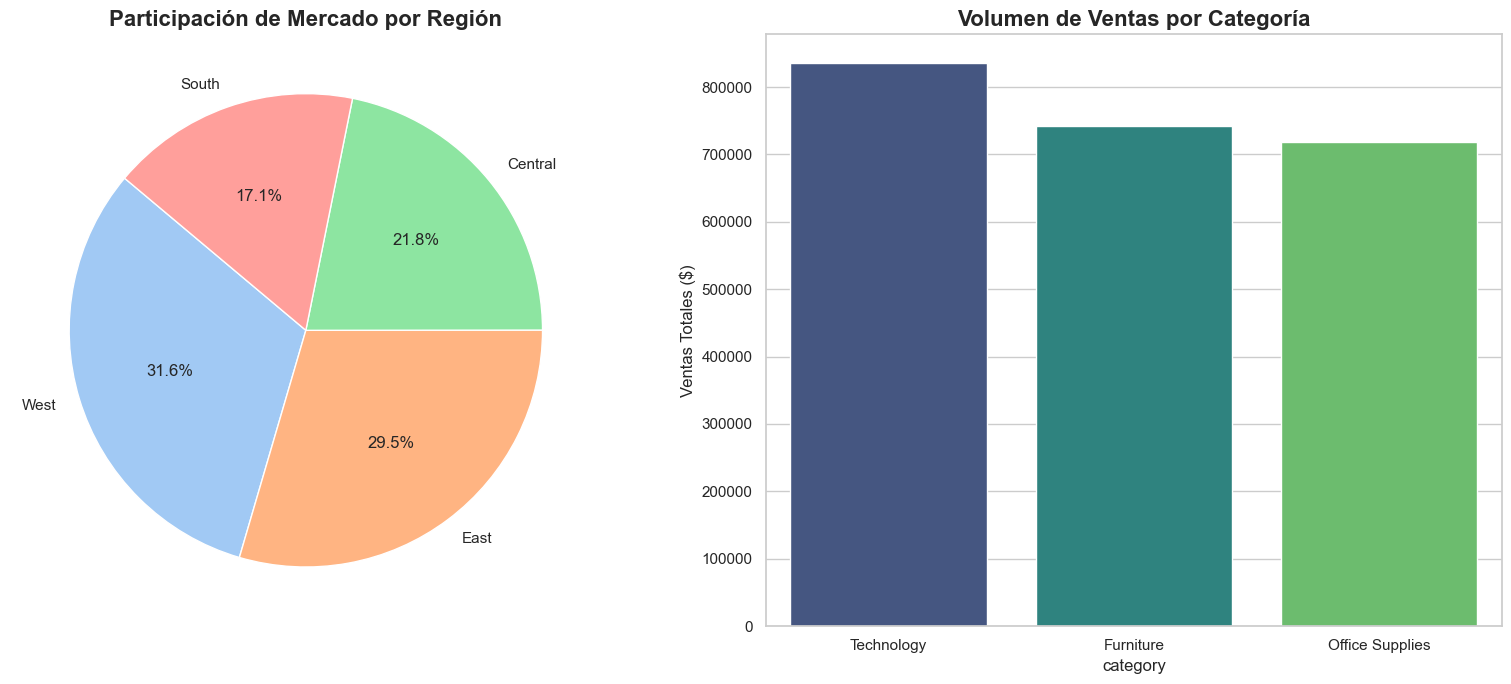

✅ Insight: 'Technology' y 'Furniture' tienen volúmenes similares, pero 'West' domina regionalmente.
   Esto confirma que un modelo general podría perder matices locales, validando los filtros del Dashboard.


In [27]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# 1. Participación por Región
region_sales = df.groupby('region')['sales'].sum().sort_values(ascending=False)
ax[0].pie(region_sales, labels=region_sales.index, autopct='%1.1f%%', startangle=140, 
          colors=sns.color_palette('pastel'), wedgeprops={'edgecolor': 'white'})
ax[0].set_title('Participación de Mercado por Región', fontweight='bold')

# 2. Ventas por Categoría Principal
cat_sales = df.groupby('category')['sales'].sum().sort_values(ascending=False)
sns.barplot(x=cat_sales.index, y=cat_sales.values, palette='viridis', ax=ax[1])
ax[1].set_title('Volumen de Ventas por Categoría', fontweight='bold')
ax[1].set_ylabel('Ventas Totales ($)')

plt.tight_layout()
plt.show()

print("✅ Insight: 'Technology' y 'Furniture' tienen volúmenes similares, pero 'West' domina regionalmente.")
print("   Esto confirma que un modelo general podría perder matices locales, validando los filtros del Dashboard.")

## 6. Prueba Estadística de Estacionariedad
Para aplicar correctamente modelos ARIMA/SARIMA, la serie debe ser estacionaria (media y varianza constantes) o diferenciable.

Aplicamos la prueba de **Dickey-Fuller Aumentada (ADF)**:
* **H0:** La serie NO es estacionaria (necesita diferenciación `d=1`).
* **H1:** La serie ES estacionaria (`d=0`).

In [ ]:
# Importaciones necesarias para asegurar que este bloque funcione por sí solo
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print('Resultados de la Prueba Dickey-Fuller:')
    
    # Ejecutar la prueba
    # autolag='AIC' elige automáticamente el número de lags que minimiza la información
    dftest = adfuller(timeseries, autolag='AIC')
    
    # Formatear la salida para que sea legible
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])
    
    # Añadir los valores críticos
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)
    
    # Interpretación automática para el jurado
    if dfoutput['p-value'] > 0.05:
        print("\n Conclusión: p-value > 0.05. No podemos rechazar H0.")
        print("   La serie NO es estacionaria (tiene raíz unitaria).")
        print(" Acción requerida: El modelo SARIMA requerirá diferenciación (d=1).")
    else:
        print("\n Conclusión: p-value < 0.05. Rechazamos H0.")
        print("   La serie ES estacionaria. No se requiere diferenciación agresiva.")

# Ejecutar sobre ventas mensuales
# Asegúrate de haber ejecutado el Bloque 6 antes para que exista 'monthly_sales'
if 'monthly_sales' in locals():
    test_stationarity(monthly_sales)
else:
    print("⚠️ Error: La variable 'monthly_sales' no está definida. Ejecuta primero el Bloque 6.")

Resultados de la Prueba Dickey-Fuller:
Test Statistic                 -4.493768
p-value                         0.000202
# Lags Used                     0.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64

🟢 Conclusión: p-value < 0.05. Rechazamos H0.
   La serie ES estacionaria. No se requiere diferenciación agresiva.


## 7. Conclusiones Finales para el Modelado

El Análisis Exploratorio de Datos ha proporcionado la hoja de ruta técnica para el desarrollo del sistema:

1.  **Estacionalidad:** La clara estacionalidad anual detectada en la descomposición y autocorrelación (Lag 12) valida el uso de componentes estacionales en SARIMA `Seasonal_Order=(..., 12)`.
2.  **Estacionariedad vs Tendencia:**
    * Aunque la prueba estadística de **Dickey-Fuller** indica estacionariedad matemática (**p-value < 0.05**), el análisis visual (Sección 3) mostró una **tendencia creciente**.
    * **Decisión de Diseño:** Por precaución y robustez, mantendremos un parámetro de diferenciación (`d=1`) en el modelo SARIMA para asegurar que el modelo capture futuros cambios en la tendencia de crecimiento.
3.  **Machine Learning:** La fuerte autocorrelación justifica el uso de **XGBoost** con características de rezago (Lags) como inputs principales.
4.  **Segmentación:** La variabilidad entre regiones justifica una arquitectura dinámica en el Dashboard.